<a href="https://colab.research.google.com/github/NikhilGeorge01/KlymoAscent1.0-Satellite-Image-SuperResolution/blob/main/satellite_image_superResolution_final_exec.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Satellite Image Super-Resolution

This notebook demonstrates 4× super-resolution on unseen Sentinel-2 imagery
using a CNN-based SRResNet model. The focus is on improving perceptual quality
while avoiding hallucinated geospatial structures.


In [11]:
!pip install rasterio scikit-image




In [12]:
import os
import cv2
import torch
import numpy as np
import rasterio
import matplotlib.pyplot as plt
import torch.nn as nn
import torch.nn.functional as F


In [13]:
# Download trained model
!wget -O srresnet_x4.pth \
https://raw.githubusercontent.com/NikhilGeorge01/KlymoAscent1.0-Satellite-Image-SuperResolution/main/assets/srresnet_x4.pth

# Download demo LR image
!wget -O Sentinel2_LR_demo.tif \
https://raw.githubusercontent.com/NikhilGeorge01/KlymoAscent1.0-Satellite-Image-SuperResolution/main/assets/Delhi_Sentinel2_LR.tif


--2026-02-03 13:31:24--  https://raw.githubusercontent.com/NikhilGeorge01/KlymoAscent1.0-Satellite-Image-SuperResolution/main/assets/srresnet_x4.pth
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 5014435 (4.8M) [application/octet-stream]
Saving to: ‘srresnet_x4.pth’

srresnet_x4.pth     100%[===================>]   4.78M  --.-KB/s    in 0.01s   

2026-02-03 13:31:25 (345 MB/s) - ‘srresnet_x4.pth’ saved [5014435/5014435]

--2026-02-03 13:31:25--  https://raw.githubusercontent.com/NikhilGeorge01/KlymoAscent1.0-Satellite-Image-SuperResolution/main/assets/Delhi_Sentinel2_LR.tif
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.c

In [14]:
class ResidualBlock(nn.Module):
    def __init__(self, channels):
        super().__init__()
        self.block = nn.Sequential(
            nn.Conv2d(channels, channels, 3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(channels, channels, 3, padding=1)
        )

    def forward(self, x):
        return x + self.block(x)


class SRResNet(nn.Module):
    def __init__(self, scale_factor=4, num_channels=3):
        super().__init__()
        self.entry = nn.Conv2d(num_channels, 64, 9, padding=4)
        self.residuals = nn.Sequential(*[ResidualBlock(64) for _ in range(8)])
        self.mid = nn.Conv2d(64, 64, 3, padding=1)
        self.upsample = nn.Sequential(
            nn.Conv2d(64, 64 * (scale_factor ** 2), 3, padding=1),
            nn.PixelShuffle(scale_factor)
        )
        self.exit = nn.Conv2d(64, num_channels, 9, padding=4)

    def forward(self, x):
        x = self.entry(x)
        res = x
        x = self.residuals(x)
        x = self.mid(x)
        x = x + res
        x = self.upsample(x)
        return self.exit(x)


In [15]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

model = SRResNet(scale_factor=4).to(device)
model.load_state_dict(torch.load("srresnet_x4.pth", map_location=device))
model.eval()

print("Model loaded successfully")


Model loaded successfully


In [16]:
with rasterio.open("Sentinel2_LR_demo.tif") as src:
    lr_img = src.read([1, 2, 3])
    lr_img = np.transpose(lr_img, (1, 2, 0))
    lr_img = lr_img.astype("float32") / 10000.0

H, W, _ = lr_img.shape
print("LR image shape:", lr_img.shape)


LR image shape: (1114, 1337, 3)


In [18]:
x = 520     # horizontal start
y = 420     # vertical start
w = 80      # width
h = 80      # height

lr_crop = lr_img[y:y+h, x:x+w]


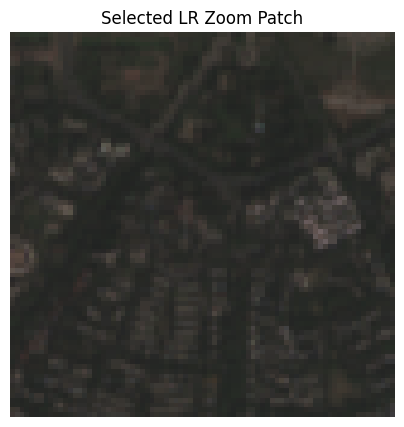

In [20]:
plt.figure(figsize=(5,5))
plt.imshow(lr_crop)
plt.title("Selected LR Zoom Patch")
plt.axis("off")
plt.show()


In [21]:
lr_crop_tensor = torch.from_numpy(lr_crop).permute(2,0,1).unsqueeze(0)

bicubic_crop = F.interpolate(
    lr_crop_tensor,
    scale_factor=4,
    mode="bicubic",
    align_corners=False
)

bicubic_crop = bicubic_crop.squeeze(0).permute(1,2,0).numpy()


In [22]:
with torch.no_grad():
    sr_crop = model(lr_crop_tensor.to(device))

sr_crop = sr_crop.squeeze(0).permute(1,2,0).cpu().numpy()
sr_crop = np.clip(sr_crop, 0, 1)


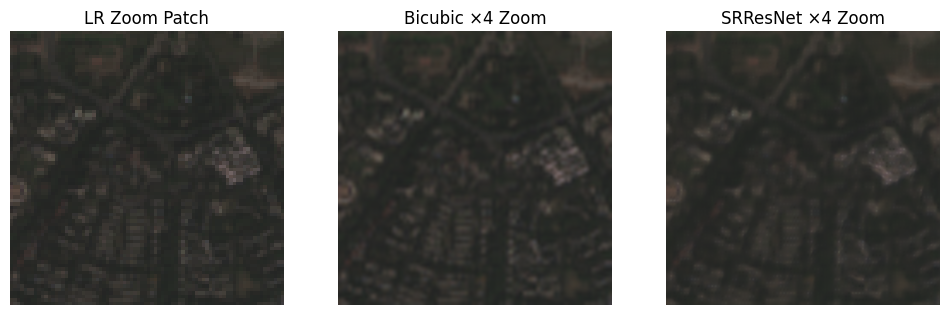

In [23]:
plt.figure(figsize=(12,4))

plt.subplot(1,3,1)
plt.imshow(lr_crop)
plt.title("LR Zoom Patch")
plt.axis("off")

plt.subplot(1,3,2)
plt.imshow(bicubic_crop)
plt.title("Bicubic ×4 Zoom")
plt.axis("off")

plt.subplot(1,3,3)
plt.imshow(sr_crop)
plt.title("SRResNet ×4 Zoom")
plt.axis("off")

plt.show()
